In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To debug, we test the case where y = x and g(y) = f(x).

A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1].$$
$f$ has a minimum at $x=1/e$ (no local minima). 

In [2]:
def func(x):
    return x * np.log(x)

def g(y, sigma = 0.01):
    return func(y) + np.random.normal(0, sigma)

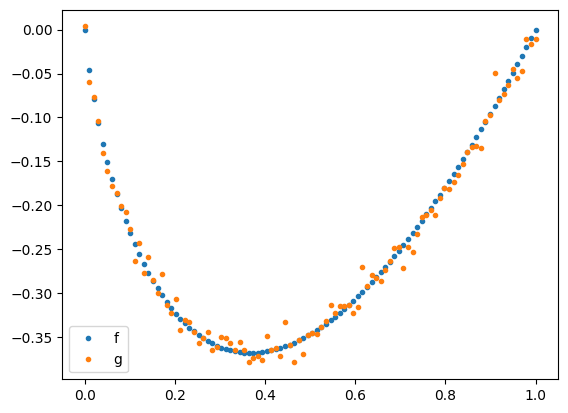

In [3]:
l = 1e-5
u = 1 - 1e-5

xs = np.linspace(l,u,100)
ys = xs
fs = func(xs)
ys2 = ys
zs = np.array([g(y) for y in ys2])

plt.plot(xs, fs, '.', label= 'f')
plt.plot(ys2, zs, '.', label= 'g')
plt.legend()

In [4]:
muz, sigmaz = zs.mean(), zs.std()
zs = (zs - muz) / sigmaz

In [5]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [6]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [7]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [8]:
individuals_posterior.sample()

tensor([ 1.2472,  1.1462,  1.0478,  0.9424,  0.8478,  0.7461,  0.6486,  0.5543,
         0.4552,  0.3691,  0.2810,  0.1894,  0.1117,  0.0268, -0.0491, -0.1327,
        -0.2034, -0.2767, -0.3481, -0.4189, -0.4819, -0.5441, -0.6063, -0.6658,
        -0.7201, -0.7687, -0.8179, -0.8636, -0.9036, -0.9447, -0.9825, -1.0141,
        -1.0458, -1.0720, -1.0887, -1.1117, -1.1282, -1.1461, -1.1535, -1.1607,
        -1.1680, -1.1697, -1.1581, -1.1641, -1.1541, -1.1368, -1.1223, -1.1086,
        -1.0880, -1.0615, -1.0347, -1.0050, -0.9734, -0.9374, -0.8995, -0.8613,
        -0.8148, -0.7730, -0.7313, -0.6711, -0.6211, -0.5603, -0.5105, -0.4529,
        -0.3889, -0.3292, -0.2686, -0.1951, -0.1268, -0.0586,  0.0129,  0.0814,
         0.1547,  0.2295,  0.3113,  0.3856,  0.4665,  0.5423,  0.6220,  0.6975,
         0.7800,  0.8553,  0.9396,  1.0266,  1.0989,  1.1781,  1.2629,  1.3490,
         1.4248,  1.4995,  1.5807,  1.6600,  1.7359,  1.8138,  1.8930,  1.9624,
         2.0426,  2.1147,  2.1882,  2.25

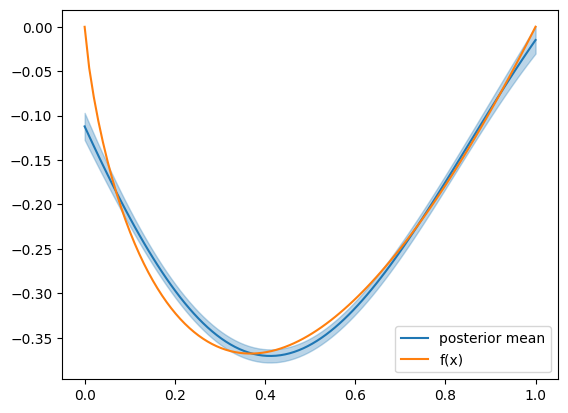

In [9]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [10]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(0.3636)

In [11]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(0.4141)

In [12]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES


x_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 3
num_round = 30
num_repeat = 3
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

In [13]:
agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/pes/',  y_min=-0.35, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
pos_best_dict['pes'] = agent_pes.simulation()

  0%|          | 0/3 [00:00<?, ?it/s]Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mengyan-zhang (oxmlgh). Use `wandb login --relogin` to force relogin


[0.37454262 0.95070528 0.73198929]


Iteration 1: Elapsed Time: 3.518890857696533 seconds


Iteration 2: Elapsed Time: 3.642860174179077 seconds


Iteration 3: Elapsed Time: 3.972888946533203 seconds


Iteration 4: Elapsed Time: 3.870414972305298 seconds


Iteration 5: Elapsed Time: 3.566969156265259 seconds


Iteration 6: Elapsed Time: 4.205500841140747 seconds


Iteration 7: Elapsed Time: 3.6583259105682373 seconds


Iteration 8: Elapsed Time: 3.5668752193450928 seconds


Iteration 9: Elapsed Time: 3.5787241458892822 seconds


Iteration 10: Elapsed Time: 3.6642251014709473 seconds


Iteration 11: Elapsed Time: 3.8669800758361816 seconds


Iteration 12: Elapsed Time: 3.713787794113159 seconds


Iteration 13: Elapsed Time: 3.7639307975769043 seconds


Iteration 14: Elapsed Time: 3.856656074523926 seconds


Iteration 15: Elapsed Time: 3.8119680881500244 seconds


Iteration 16: Elapsed Time: 3.8798770904541016 seconds


Iteration 17: Elapsed Time: 3.9517829418182373 seconds


Iteration 18: Elapsed Time: 4.090612888336182 seconds


Iteration 19: Elapsed Time: 4.257794141769409 seconds


Iteration 20: Elapsed Time: 4.2567138671875 seconds


Iteration 21: Elapsed Time: 4.156759023666382 seconds


Iteration 22: Elapsed Time: 5.976873874664307 seconds


Iteration 23: Elapsed Time: 5.95589804649353 seconds


Iteration 24: Elapsed Time: 6.12589693069458 seconds


Iteration 25: Elapsed Time: 6.021268129348755 seconds


Iteration 26: Elapsed Time: 6.16665506362915 seconds


100%|██████████| 27/27 [01:59<00:00,  4.41s/it]

Iteration 27: Elapsed Time: 7.211450099945068 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▁▁▂▂▁▂▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▆▆▆▆▆█
pos_best,█▃▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
regret,█▃▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
x_opt,▆▃█▁▂▅▄▇▂▁▃▆▃█▅▂▄▄▄▇▄▇▁██▇█
y_rec,▁█▁████▁███▁█▁█████▁█▁█▁▁▁▁
z_reward,▆▄▄▄▃▁▆▆▂▄▄▄▂▄▅█▅▅▄▄▆▅▄▃▄▄▅
elapsed_time,7.21145
pos_best,-0.36509
regret,0.00277
x_opt,0.60303
y_rec,1e-05


 33%|███▎      | 1/3 [02:11<04:23, 131.84s/it]

[0.01749992 0.89156542 0.28486547]


Iteration 1: Elapsed Time: 3.3577499389648438 seconds


Iteration 2: Elapsed Time: 3.4941999912261963 seconds


Iteration 3: Elapsed Time: 3.5165398120880127 seconds


Iteration 4: Elapsed Time: 3.415040969848633 seconds


Iteration 5: Elapsed Time: 3.5474750995635986 seconds


Iteration 6: Elapsed Time: 3.5536398887634277 seconds


Iteration 7: Elapsed Time: 3.7143778800964355 seconds


Iteration 8: Elapsed Time: 3.6447019577026367 seconds


Iteration 9: Elapsed Time: 3.8217170238494873 seconds


Iteration 10: Elapsed Time: 3.7844228744506836 seconds


Iteration 11: Elapsed Time: 3.695693016052246 seconds


Iteration 12: Elapsed Time: 3.733833074569702 seconds


Iteration 13: Elapsed Time: 3.950131893157959 seconds


Iteration 14: Elapsed Time: 3.9209179878234863 seconds


Iteration 15: Elapsed Time: 3.9381661415100098 seconds


Iteration 16: Elapsed Time: 3.973250150680542 seconds


Iteration 17: Elapsed Time: 4.010439872741699 seconds


Iteration 18: Elapsed Time: 4.059565782546997 seconds


Iteration 19: Elapsed Time: 4.06911301612854 seconds


Iteration 20: Elapsed Time: 4.04250431060791 seconds


Iteration 21: Elapsed Time: 4.244617938995361 seconds


Iteration 22: Elapsed Time: 5.517267942428589 seconds


Iteration 23: Elapsed Time: 5.892864942550659 seconds


Iteration 24: Elapsed Time: 6.113322973251343 seconds


Iteration 25: Elapsed Time: 6.070454120635986 seconds


Iteration 26: Elapsed Time: 5.9738359451293945 seconds


100%|██████████| 27/27 [01:56<00:00,  4.32s/it]

Iteration 27: Elapsed Time: 7.585914134979248 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▆▅▅█
pos_best,▁▁██▃▁▃▃▂▁▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁
regret,▁▁██▃▁▃▃▂▁▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁
x_opt,▆▇▇▄▆█▄▃▁▄▅▅▆▅█▆▅▂▁▇▃▃▄▄▂▆▄
y_rec,▁▁▁█▁▁████▁▁▁▁▁▁▁██▁█████▁█
z_reward,▄█▁▃▄▄▃▄█▂▆▂▄▃▄▅▂▆█▁▆▂▂▃▅▃▅
elapsed_time,7.58591
pos_best,-0.36705
regret,0.00081
x_opt,0.46869
y_rec,0.99999


 67%|██████▋   | 2/3 [04:20<02:09, 129.97s/it]

[0.83483544 0.10480401 0.74463558]


Iteration 1: Elapsed Time: 3.371077299118042 seconds


Iteration 2: Elapsed Time: 3.6026949882507324 seconds


Iteration 3: Elapsed Time: 3.3503661155700684 seconds


Iteration 4: Elapsed Time: 3.421452045440674 seconds


Iteration 5: Elapsed Time: 3.577207088470459 seconds


Iteration 6: Elapsed Time: 3.606088161468506 seconds


Iteration 7: Elapsed Time: 3.54789662361145 seconds


Iteration 8: Elapsed Time: 3.6043858528137207 seconds


Iteration 9: Elapsed Time: 3.706529140472412 seconds


Iteration 10: Elapsed Time: 3.665825843811035 seconds


Iteration 11: Elapsed Time: 3.786673069000244 seconds


Iteration 12: Elapsed Time: 3.74141788482666 seconds


Iteration 13: Elapsed Time: 3.824354887008667 seconds


Iteration 14: Elapsed Time: 3.840193033218384 seconds


Iteration 15: Elapsed Time: 3.9816629886627197 seconds


Iteration 16: Elapsed Time: 3.928339958190918 seconds


Iteration 17: Elapsed Time: 4.001201868057251 seconds


Iteration 18: Elapsed Time: 3.9154810905456543 seconds


Iteration 19: Elapsed Time: 4.045458793640137 seconds


Iteration 20: Elapsed Time: 4.434638023376465 seconds


Iteration 21: Elapsed Time: 4.160860776901245 seconds


Iteration 22: Elapsed Time: 5.7527806758880615 seconds


Iteration 23: Elapsed Time: 5.999199151992798 seconds


Iteration 24: Elapsed Time: 6.020370006561279 seconds


Iteration 25: Elapsed Time: 5.9659600257873535 seconds


Iteration 26: Elapsed Time: 6.051612854003906 seconds


100%|██████████| 27/27 [01:56<00:00,  4.31s/it]

Iteration 27: Elapsed Time: 7.27532696723938 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▂▅▆▆▆▆█
pos_best,█▄▁▂▁▁▂▅██▁▂████▂▁▂▂▁▁▁▁▁▁▁
regret,█▄▁▂▁▁▂▅██▁▂████▂▁▂▂▁▁▁▁▁▁▁
x_opt,▃▅▄▅▄▃▃▄▄▅▃▄▄▁▃█▅▃▃█▄▅▄▆▄▃▅
y_rec,█▁█▁█████▁█████▁▁██▁█▁█▁██▁
z_reward,█▆▁▁▃▅▅▆▇▆▃▅▃▅▆▇▆▆▃▅▅▅▅█▅▆▁
elapsed_time,7.27533
pos_best,-0.3618
regret,0.00606
x_opt,0.51414
y_rec,1e-05


100%|██████████| 3/3 [06:26<00:00, 128.94s/it]


<Figure size 640x480 with 0 Axes>

In [14]:
agent_pes.z_rewards

tensor([-0.1644, -0.2500, -0.2348,  0.0156,  0.0027, -0.0259, -0.0230, -0.0137,
        -0.0025, -0.0034,  0.0032,  0.0084,  0.0057, -0.0122, -0.0013, -0.0112,
        -0.0037,  0.0057,  0.0086,  0.0038,  0.0020, -0.0114, -0.0034, -0.0034,
        -0.0013, -0.0016,  0.0141, -0.0022,  0.0030, -0.0236])

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


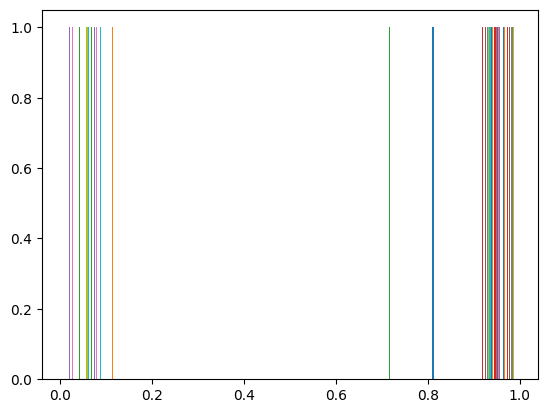

In [15]:
plt.hist(agent_pes.y_recs)

In [16]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [17]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/3 [00:00<?, ?it/s]

[0.37454262 0.95070528 0.73198929]


Iteration 1: Elapsed Time: 3.0330610275268555 seconds


Iteration 2: Elapsed Time: 2.9675710201263428 seconds


Iteration 3: Elapsed Time: 2.7950589656829834 seconds


Iteration 4: Elapsed Time: 2.669595241546631 seconds


Iteration 5: Elapsed Time: 2.8398971557617188 seconds


Iteration 6: Elapsed Time: 2.7327239513397217 seconds


Iteration 7: Elapsed Time: 2.745142698287964 seconds


Iteration 8: Elapsed Time: 2.8212130069732666 seconds


Iteration 9: Elapsed Time: 2.7670350074768066 seconds


Iteration 10: Elapsed Time: 2.779507875442505 seconds


Iteration 11: Elapsed Time: 2.7121458053588867 seconds


Iteration 12: Elapsed Time: 2.778804063796997 seconds


Iteration 13: Elapsed Time: 2.7555878162384033 seconds


Iteration 14: Elapsed Time: 2.770397186279297 seconds


Iteration 15: Elapsed Time: 2.7649238109588623 seconds


Iteration 16: Elapsed Time: 2.8579251766204834 seconds


Iteration 17: Elapsed Time: 2.7748851776123047 seconds


Iteration 18: Elapsed Time: 2.8195488452911377 seconds


Iteration 19: Elapsed Time: 2.7592949867248535 seconds


Iteration 20: Elapsed Time: 2.858273983001709 seconds


Iteration 21: Elapsed Time: 2.7778539657592773 seconds


Iteration 22: Elapsed Time: 2.908417224884033 seconds


Iteration 23: Elapsed Time: 2.916975736618042 seconds


Iteration 24: Elapsed Time: 2.8926448822021484 seconds


Iteration 25: Elapsed Time: 2.7998762130737305 seconds


Iteration 26: Elapsed Time: 2.8786139488220215 seconds


100%|██████████| 27/27 [01:16<00:00,  2.82s/it]

Iteration 27: Elapsed Time: 2.890042781829834 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,█▇▃▁▄▂▂▄▃▃▂▃▃▃▃▅▃▄▃▅▃▆▆▅▄▅▅
pos_best,██▁█▂▃▃▄▃▂▂▂▂▁▁▁▁▁▁▁█▁▁▁▁▁▁
regret,██▁█▂▃▃▄▃▂▂▂▂▁▁▁▁▁▁▁█▁▁▁▁▁▁
y_rec,▆▁▂▃▃▅▄▄▅▅▂▁▂▆▅▁▆▃▂██▂▃▇▅▂▆
z_reward,▄▇▂▁▂▃▁▁▂▃▃▅▄▃▂▆▃▂▃█▇▄▁▅▂▃▄
elapsed_time,2.89004
pos_best,-0.3618
regret,0.00606
y_rec,0.729
z_reward,-0.22154


 33%|███▎      | 1/3 [01:27<02:54, 87.40s/it]

[0.01749992 0.89156542 0.28486547]


Iteration 1: Elapsed Time: 2.759489059448242 seconds


Iteration 2: Elapsed Time: 2.8336338996887207 seconds


Iteration 3: Elapsed Time: 2.769881010055542 seconds


Iteration 4: Elapsed Time: 2.685701847076416 seconds


Iteration 5: Elapsed Time: 2.7422220706939697 seconds


Iteration 6: Elapsed Time: 2.697359800338745 seconds


Iteration 7: Elapsed Time: 2.7547109127044678 seconds


Iteration 8: Elapsed Time: 2.716541051864624 seconds


Iteration 9: Elapsed Time: 2.7690980434417725 seconds


Iteration 10: Elapsed Time: 2.676264762878418 seconds


Iteration 11: Elapsed Time: 2.829303026199341 seconds


Iteration 12: Elapsed Time: 2.6915781497955322 seconds


Iteration 13: Elapsed Time: 2.783041000366211 seconds


Iteration 14: Elapsed Time: 2.6867008209228516 seconds


Iteration 15: Elapsed Time: 2.766390085220337 seconds


Iteration 16: Elapsed Time: 2.7167348861694336 seconds


Iteration 17: Elapsed Time: 2.813626766204834 seconds


Iteration 18: Elapsed Time: 2.737955093383789 seconds


Iteration 19: Elapsed Time: 2.7808539867401123 seconds


Iteration 20: Elapsed Time: 2.7379889488220215 seconds


Iteration 21: Elapsed Time: 2.8575222492218018 seconds


Iteration 22: Elapsed Time: 2.7407400608062744 seconds


Iteration 23: Elapsed Time: 2.7893569469451904 seconds


Iteration 24: Elapsed Time: 2.7495810985565186 seconds


Iteration 25: Elapsed Time: 2.788410186767578 seconds


Iteration 26: Elapsed Time: 2.736081838607788 seconds


100%|██████████| 27/27 [01:14<00:00,  2.76s/it]

Iteration 27: Elapsed Time: 2.8102738857269287 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▄▇▅▁▄▂▄▃▅▁▇▂▅▁▄▃▆▃▅▃█▃▅▄▅▃▆
pos_best,▁▂█▃▅▆▄▄▅▅▇▆▆▁▇▃▂▂▂▂▂▂▁▁▁▁▁
regret,▁▂█▃▅▆▄▄▅▅▇▆▆▁▇▃▂▂▂▂▂▂▁▁▁▁▁
y_rec,▄▅▂▄▅▃▄▂▆▅▄▄▇▁▆▃▆█▆▆▂▁▅▇▄█▇
z_reward,▁▂▃▁▃▁▁▃▃▂▁▁▅▆▅▁▃▇▃▃▂▆▂▇▁█▇
elapsed_time,2.81027
pos_best,-0.36359
regret,0.00427
y_rec,0.90701
z_reward,-0.09164


 67%|██████▋   | 2/3 [02:52<01:25, 85.84s/it]

[0.83483544 0.10480401 0.74463558]


Iteration 1: Elapsed Time: 2.8695781230926514 seconds


Iteration 2: Elapsed Time: 3.1659457683563232 seconds


Iteration 3: Elapsed Time: 3.133533239364624 seconds


Iteration 4: Elapsed Time: 2.956613779067993 seconds


Iteration 5: Elapsed Time: 2.8281590938568115 seconds


Iteration 6: Elapsed Time: 2.8540608882904053 seconds


Iteration 7: Elapsed Time: 2.797119140625 seconds


Iteration 8: Elapsed Time: 2.9167320728302 seconds


Iteration 9: Elapsed Time: 2.9786200523376465 seconds


Iteration 10: Elapsed Time: 2.924593925476074 seconds


Iteration 11: Elapsed Time: 2.961171865463257 seconds


Iteration 12: Elapsed Time: 2.9483370780944824 seconds


Iteration 13: Elapsed Time: 3.0497050285339355 seconds


Iteration 14: Elapsed Time: 3.032896041870117 seconds


Iteration 15: Elapsed Time: 2.777575731277466 seconds


Iteration 16: Elapsed Time: 2.791297197341919 seconds


Iteration 17: Elapsed Time: 2.906045913696289 seconds


Iteration 18: Elapsed Time: 2.929574966430664 seconds


Iteration 19: Elapsed Time: 3.0360758304595947 seconds


Iteration 20: Elapsed Time: 3.0135419368743896 seconds


Iteration 21: Elapsed Time: 3.0052337646484375 seconds


Iteration 22: Elapsed Time: 2.8416759967803955 seconds


Iteration 23: Elapsed Time: 2.994565725326538 seconds


Iteration 24: Elapsed Time: 2.7962028980255127 seconds


Iteration 25: Elapsed Time: 3.111503839492798 seconds


Iteration 26: Elapsed Time: 2.972327947616577 seconds


100%|██████████| 27/27 [01:19<00:00,  2.95s/it]

Iteration 27: Elapsed Time: 2.9543609619140625 seconds



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


elapsed_time,▃█▇▄▂▂▁▄▅▄▄▄▆▆▁▁▃▄▆▅▅▂▅▁▇▅▄
pos_best,███████████▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁
regret,███████████▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁
y_rec,▄▄▁▂▂▅▇▂▂▅▁▂█▇▁▆▆▆▄▁▂▂▄▃▇▃▃
z_reward,▁▁▃▂▂▃▆▂▃▂▄▂█▅▅▄▄▃▁▄▂▃▁▁▅▁▁
elapsed_time,2.95436
pos_best,-0.36785
regret,0.0
y_rec,0.30895
z_reward,-0.36214


100%|██████████| 3/3 [04:21<00:00, 87.28s/it]


<Figure size 640x480 with 0 Axes>

(array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],


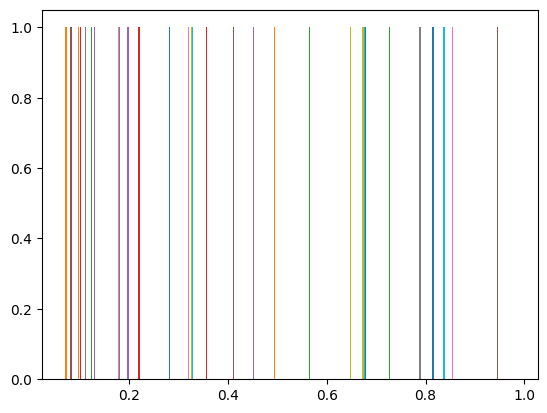

In [18]:
plt.hist(agent_random.y_recs)

In [24]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        print(regret_mean)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  
    plt.ylim(0,0.3)

[0.24542855 0.08595566 0.12381733 0.16011675 0.03297697 0.00745657
 0.04236548 0.2171733  0.13275819 0.12287977 0.00110616 0.01881661
 0.12659007 0.13020606 0.1346201  0.13805954 0.03471286 0.02982711
 0.02287134 0.0163792  0.00974517 0.00922315 0.00302198 0.00469307
 0.00027598 0.00204963 0.00321174]
[0.24542855 0.2490644  0.14960311 0.25277868 0.15811548 0.16965652
 0.16865356 0.1812502  0.16540267 0.15429035 0.16008171 0.12572452
 0.11739358 0.00953695 0.02799328 0.0104096  0.016179   0.0154296
 0.01307773 0.00977324 0.12624307 0.00721833 0.00236343 0.0026756
 0.00354828 0.00265623 0.00344228]


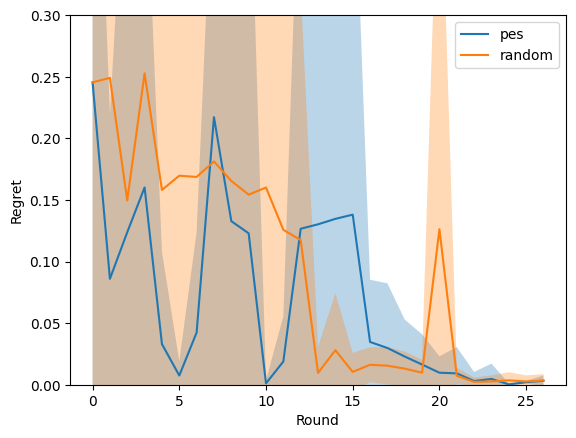

In [25]:
evalaution(pos_best_dict)

In [21]:
pos_best_dict['pes'][-1]


[tensor(-0.0001),
 tensor(-0.2033),
 tensor(-0.3670),
 tensor(-0.3100),
 tensor(-0.3604),
 tensor(-0.3597),
 tensor(-0.3391),
 tensor(-0.1699),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.3651),
 tensor(-0.3231),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.0001),
 tensor(-0.3231),
 tensor(-0.3435),
 tensor(-0.3342),
 tensor(-0.3342),
 tensor(-0.3511),
 tensor(-0.3435),
 tensor(-0.3597),
 tensor(-0.3544),
 tensor(-0.3670),
 tensor(-0.3651),
 tensor(-0.3618)]

In [22]:
# np.save('pos-seed24.npy', pos_best_dict)